In [12]:
import sys
import numpy as np
import astropy.io.fits as pf
from astropy.table import Table, vstack
import pylab as mplot
import yaml
import h5py
import healpy as hp
import scipy
from scipy import interpolate

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [13]:
tag = '0613'
project_dir = '/project/chihway/data/decade/'

In [14]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:

    print(h5r.keys())
    ids = h5r['COADD_OBJECT_ID'][:]

<KeysViewHDF5 ['BDF_FLUX_ERR_G', 'BDF_FLUX_ERR_I', 'BDF_FLUX_ERR_R', 'BDF_FLUX_ERR_Z', 'BDF_FLUX_G', 'BDF_FLUX_I', 'BDF_FLUX_R', 'BDF_FLUX_Z', 'BDF_S2N', 'BDF_T', 'COADD_OBJECT_ID', 'DEC', 'FLAGS_FOREGROUND', 'FLUXERR_AUTO_G', 'FLUXERR_AUTO_I', 'FLUXERR_AUTO_R', 'FLUXERR_AUTO_Z', 'FLUX_AUTO_G', 'FLUX_AUTO_I', 'FLUX_AUTO_R', 'FLUX_AUTO_Z', 'FLUX_RADIUS_G', 'FLUX_RADIUS_I', 'FLUX_RADIUS_R', 'FLUX_RADIUS_Z', 'Ncutouts_raw', 'RA', 'badfrac', 'id', 'mcal_T_1m', 'mcal_T_1p', 'mcal_T_2m', 'mcal_T_2p', 'mcal_T_noshear', 'mcal_T_ratio_1m', 'mcal_T_ratio_1p', 'mcal_T_ratio_2m', 'mcal_T_ratio_2p', 'mcal_T_ratio_noshear', 'mcal_flags', 'mcal_flux_1m', 'mcal_flux_1p', 'mcal_flux_2m', 'mcal_flux_2p', 'mcal_flux_err_1m', 'mcal_flux_err_1p', 'mcal_flux_err_2m', 'mcal_flux_err_2p', 'mcal_flux_err_noshear', 'mcal_flux_noshear', 'mcal_g_1m', 'mcal_g_1p', 'mcal_g_2m', 'mcal_g_2p', 'mcal_g_cov_1m', 'mcal_g_cov_1p', 'mcal_g_cov_2m', 'mcal_g_cov_2p', 'mcal_g_cov_noshear', 'mcal_g_noshear', 'mcal_g_w', 'mcal_

In [15]:
tomo = np.load('/project/chihway/raulteixeira/data/BPZ+SOM_mcal_gold_wide_26x26_ids+cells+fluxes_TomoBins.npz')

In [16]:
tomo['arr_0'].shape

#['COADD_OBJECT_ID', 'FLUX_R', 'FLUX_ERR_R', 'FLUX_I', 'FLUX_ERR_I',
#        'FLUX_Z', 'FLUX_ERR_Z', 'cells', 'CHI_SQ', 'ID', 'M_0', 'ODDS', 'T_B',
#        'T_ML', 'Z_B', 'Z_B_MAX', 'Z_B_MIN', 'Z_MEAN', 'Z_ML', 'Z_SAMP',
#        'Z_SIG', 'MAG_R', 'MAG_I', 'MAG_Z', 'TomoBin']

(47341776,)

In [17]:
len(ids)

244200019

In [18]:
# first get mask total

with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]
    sg = h5r['sg_bdf'][:] 
    fg = h5r['FLAGS_FOREGROUND'][:] 
    T = h5r['mcal_T_noshear'][:]
    mcal_flags = h5r['mcal_flags'][:]
    g1, g2  = h5r['mcal_g_noshear'][:].T
    flux_r, flux_i, flux_z = h5r['mcal_flux_noshear'][:].T

mag_r = -2.5*np.log10(flux_r)+30
mag_i = -2.5*np.log10(flux_i)+30
mag_z = -2.5*np.log10(flux_z)+30

# PZ mask
mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                    (mag_r < 26)   & (mag_r > 15) & 
                    (mag_z < 26)   & (mag_z > 15) & 
                    (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                    (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

# Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
SNR_Mask   = (s2n > 10) & (s2n < 1000)
Tratio_Mask= size_ratio > 0.5
T_Mask = T < 10
Flag_Mask = (mcal_flags == 0)
Other_Mask = np.invert((T > 2) & (s2n < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))
SG_Mask = (sg>=4)
FG_Mask = (fg==0)

mask_total = mcal_pz_mask & SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Other_Mask & SG_Mask & FG_Mask

del size_ratio, s2n, sg, fg, T, mcal_flags, g1, g2, flux_r, flux_i, flux_z, mag_r, mag_i, mag_z
del mcal_pz_mask, SNR_Mask, Tratio_Mask, T_Mask, Flag_Mask, Other_Mask, SG_Mask

/home/chihway/ipykernel_1072544/2547016843.py:13: RuntimeWarning: invalid value encountered in log10
  mag_r = -2.5*np.log10(flux_r)+30
/home/chihway/ipykernel_1072544/2547016843.py:14: RuntimeWarning: invalid value encountered in log10
  mag_i = -2.5*np.log10(flux_i)+30
/home/chihway/ipykernel_1072544/2547016843.py:15: RuntimeWarning: invalid value encountered in log10
  mag_z = -2.5*np.log10(flux_z)+30
/home/chihway/ipykernel_1072544/2547016843.py:29: RuntimeWarning: invalid value encountered in log10
  Other_Mask = np.invert((T > 2) & (s2n < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))


In [19]:
len(ids[mask_total])

47349243

In [20]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:

#     print(h5r.keys())
    ra = h5r['RA'][:]
    print('ra')
    dec = h5r['DEC'][:]
    print('dec')
    w = h5r['mcal_g_w_v2'][:]   
    print('w')
    g1, g2  = h5r['mcal_g_noshear'][:].T
    print('g')

ra
dec
w
g


In [21]:
ra = ra[mask_total]
dec = dec[mask_total]
w = w[mask_total]
g1 = g1[mask_total]
g2 = g2[mask_total]

In [22]:
ids_tomo = tomo['arr_0']['COADD_OBJECT_ID']
tomo_tomo = tomo['arr_0']['TomoBin']
z_samp_tomo = tomo['arr_0']['Z_SAMP']



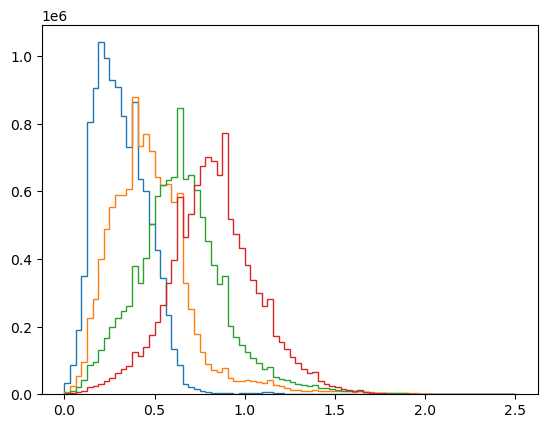

In [23]:
#Lucas' modifications below will save the nzs to cosmocov-ready format
d_bins={}
for i in range(4):
    mask_bin = (tomo_tomo == i+1)
    z_bin = z_samp_tomo[mask_bin]
    #saving to a dictionary:
    bins_z_,edges_z_ = np.histogram(z_bin,bins=80,range=[0,2.5],density=True)
    mid_z_ = 0.5*(edges_z_[1:]+edges_z_[:-1])
    d_bins['bin%d'%i]=[mid_z_,bins_z_]
    #plot
    mplot.hist(z_bin, range=(0,2.5), bins=80, histtype='step')

outfile_z_ = open('delve_nzs_%s.nz'%tag,'w')
for i in range(len(d_bins['bin0'][0])):
    outfile_z_.write('%f %1.6e %1.6e %1.6e %1.6e\n'%(d_bins['bin0'][0][i],
                                            d_bins['bin0'][1][i],
                                            d_bins['bin1'][1][i],
                                            d_bins['bin2'][1][i],
                                            d_bins['bin3'][1][i]))
outfile_z_.close()
del d_bins

In [24]:
# match tomo and metacal (there's a small number of missing galaxies in the tomo file)

mask_tomo = np.in1d(ids[mask_total], ids_tomo)
ids = ids[mask_total][mask_tomo]
ra = ra[mask_tomo]
dec = dec[mask_tomo]
w = w[mask_tomo]
g1 = g1[mask_tomo]
g2 = g2[mask_tomo]

print(len(ids))

47341776


In [25]:
# reorder by ids

X = np.argsort(ids)
ids = ids[X]
ra = ra[X]
dec = dec[X]

Y = np.argsort(ids_tomo)
ids_tomo = ids_tomo[Y]
tomo_tomo = tomo_tomo[Y]
z_samp_tomo = z_samp_tomo[Y]

In [26]:
print(tomo_tomo)
print(ids)
print(ids_tomo)

[4 2 2 ... 2 4 3]
[6901809260 6901809285 6901809304 ... 7255613797 7255613815 7255613822]
[6901809260 6901809285 6901809304 ... 7255613797 7255613815 7255613822]


In [27]:
nside = 4096
map_counts = np.zeros(hp.nside2npix(nside))

phi = ra/180*np.pi
theta = (90.-dec)/180*np.pi

pix = hp.ang2pix(nside, theta, phi)

for i in range(len(pix)):
    map_counts[pix[i]] += 1
    
area = len(map_counts[map_counts>0])/len(map_counts)*4*np.pi*(180./np.pi)**2*60*60
print('area', area/60/60, 'deg^2')

print('total', len(ra)/area, '/arcmin^2')

area 2376.2550507403184 deg^2
total 5.534125357981384 /arcmin^2


In [28]:
# use mean response for everything, this is from CalculateNeff notebook
# R11 0.7443824304923087 R11s 0.047189013967600654
# R22 0.7455737932558067 R22s 0.04767254335307269
# R11tot 0.7915714444599093 R22tot 0.7932463366088794

In [29]:
def neff_H12(w, A):
    return 1./A * (np.sum(w)**2) / (np.sum(w**2))

def sigmae2_H12(w, g1, R1, g2, R2, neff, A):
    return 0.5*((np.sum(w**2*(g1/R1)**2)/(np.sum(w))**2)
                        +(np.sum(w**2*(g2/R2)**2)/(np.sum(w))**2))*(A*neff)


R1 = 0.7915714444599093
R2 = 0.7932463366088794

In [30]:
print("Bin     total ngal    raw ngal(/arcmin^2)  neff(/arcmin^2)     sigmae ")
print("======================================================================")
for i in range(4):
    mask_bin = (tomo_tomo == i+1)
    w_bin = w[mask_bin]
    g1_bin = g1[mask_bin]
    g2_bin = g2[mask_bin]
    
    neff = neff_H12(w_bin, area)
    sigmae2 = sigmae2_H12(w_bin, g1_bin, R1, g2_bin, R2, neff, area)

    print(str(i+1)+"\t"+ str(len(ids[mask_bin]))+"\t \t"+str(len(ids[mask_bin])/area)[:7]+"\t\t"+str(neff)[:7]+"\t\t"+str(sigmae2**0.5)[:7])

Bin     total ngal    raw ngal(/arcmin^2)  neff(/arcmin^2)     sigmae 
1	11793578	 	1.37863		1.14119		0.23765
2	11859295	 	1.38631		1.14746		0.23764
3	11797811	 	1.37913		1.14160		0.23756
4	11891092	 	1.39003		1.15051		0.23760


Text(0.5, 0, 'z')

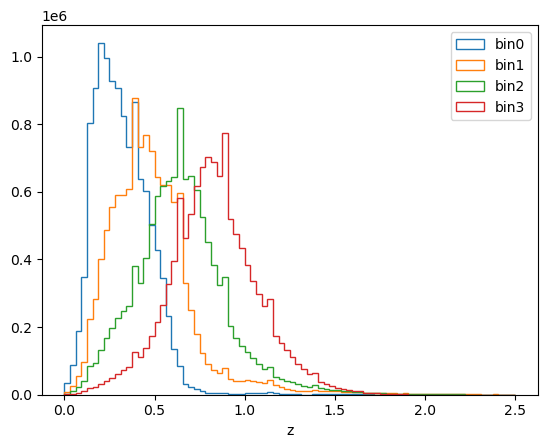

In [31]:
for i in range(4):
    mask_bin = (tomo_tomo == i+1)
    z_bin = z_samp_tomo[mask_bin]
    output = mplot.hist(z_bin, range=(0,2.5), bins=80, histtype='step', label='bin'+str(i))
    np.savetxt('/project/chihway/data/decade/forecast/v1/zbin_'+str(i)+'.txt', np.vstack([(output[1][:-1]+output[1][1:])/2, output[0]/np.sum(output[0])]).T)
mplot.legend()
mplot.xlabel('z')

## Full catalog (1002)

In [32]:
tag = '1002'
project_dir = '/project/chihway/data/decade/'

In [33]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:

    print(h5r.keys())
    ids = h5r['COADD_OBJECT_ID'][:]

<KeysViewHDF5 ['BDF_FLUX_ERR_G', 'BDF_FLUX_ERR_I', 'BDF_FLUX_ERR_R', 'BDF_FLUX_ERR_Z', 'BDF_FLUX_G', 'BDF_FLUX_I', 'BDF_FLUX_R', 'BDF_FLUX_Z', 'BDF_S2N', 'BDF_T', 'COADD_OBJECT_ID', 'DEC', 'FLAGS_FOREGROUND', 'FLUXERR_AUTO_G', 'FLUXERR_AUTO_I', 'FLUXERR_AUTO_R', 'FLUXERR_AUTO_Z', 'FLUX_AUTO_G', 'FLUX_AUTO_I', 'FLUX_AUTO_R', 'FLUX_AUTO_Z', 'FLUX_RADIUS_G', 'FLUX_RADIUS_I', 'FLUX_RADIUS_R', 'FLUX_RADIUS_Z', 'Ncutouts_raw', 'RA', 'badfrac', 'id', 'mcal_T_1m', 'mcal_T_1p', 'mcal_T_2m', 'mcal_T_2p', 'mcal_T_noshear', 'mcal_T_ratio_1m', 'mcal_T_ratio_1p', 'mcal_T_ratio_2m', 'mcal_T_ratio_2p', 'mcal_T_ratio_noshear', 'mcal_flags', 'mcal_flux_1m', 'mcal_flux_1p', 'mcal_flux_2m', 'mcal_flux_2p', 'mcal_flux_err_1m', 'mcal_flux_err_1p', 'mcal_flux_err_2m', 'mcal_flux_err_2p', 'mcal_flux_err_noshear', 'mcal_flux_noshear', 'mcal_g_1m', 'mcal_g_1p', 'mcal_g_2m', 'mcal_g_2p', 'mcal_g_cov_1m', 'mcal_g_cov_1p', 'mcal_g_cov_2m', 'mcal_g_cov_2p', 'mcal_g_cov_noshear', 'mcal_g_noshear', 'mcal_g_w', 'mcal_